# Historical emmission from Climatewatch

They are a secondary source of info, currently downloaded a csv with all their data but they also have an API.


In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import requests
import os
import numpy as np

In [2]:
# Go to repository root directory
if "_changed_dir" not in locals():
    os.chdir("../")
    _changed_dir = True

Data already downloaded it's in file:
`Covid_Hackathon_2\data\raw\historical_emissions\historical_emissions.csv`

In addition the following file provides information about the sources of data
`Covid_Hackathon_2\data\raw\historical_emissions\Sources.csv`


In [3]:
file_path = 'data/raw/historical_emissions/historical_emissions.csv'

In [4]:
ghg_all = pd.read_csv(file_path)

## Dataset features

This dataset is a bit tricky because it's so comprehensive.

First let's look at the available columns:

In [5]:
ghg_all.columns[:6]

Index(['Country', 'Data source', 'Sector', 'Gas', 'Unit', '2018'], dtype='object')

Let's define `id_columns` for all those containing info about a data set.

In [6]:
id_columns = ghg_all.columns[:5]

In [7]:
def print_df_info(ghg_all, id_columns, limit_print_len = 12):
    for col in id_columns:
        u_id = ghg_all[col].unique()
        print(f"'{col}' has {len(u_id)} unique items:")
        if limit_print_len > 0:
            if len(u_id) < limit_print_len:
                print(f"\t{u_id}")
            else:
                print(f"\t{u_id[:limit_print_len]} .....")
            print("_________")

In [8]:
print_df_info(ghg_all, id_columns)

'Country' has 217 unique items:
	['Afghanistan' 'Albania' 'Algeria'
 'Alliance of Small Island States (AOSIS)' 'Andorra' 'Angola' 'Anguilla'
 'Annex-I Parties to the Convention' 'Antarctica' 'Antigua and Barbuda'
 'Argentina' 'Armenia'] .....
_________
'Data source' has 5 unique items:
	['PIK' 'UNFCCC_NAI' 'CAIT' 'GCP' 'UNFCCC_AI']
_________
'Sector' has 30 unique items:
	['Industrial Processes and Product Use'
 'Total GHG emissions including LULUCF/LUCF' 'Industrial Processes'
 'Agriculture' 'Solvent and Other Product Use' 'Other Fuel Combustion'
 'Waste' 'Total GHG emissions excluding LULUCF/LUCF'
 'Total excluding LULUCF' 'Oil' 'Energy' 'Fugitive Emissions'] .....
_________
'Gas' has 11 unique items:
	['CO2' 'Aggregate GHGs' 'KYOTOGHG' 'N2O' 'All GHG' 'CH4' 'N₂O' 'CH₄' 'CO₂'
 'F-Gas' 'Aggregate F-gases']
_________
'Unit' has 1 unique items:
	['MtCO₂e']
_________


In [9]:
ghg_all.Gas[ghg_all.Gas == 'CO₂'] = 'CO2'
ghg_all.Gas[ghg_all.Gas == 'N₂O'] = 'N2O'
ghg_all.Gas[ghg_all.Gas == 'CH₄'] = 'CH4'

In [10]:

date_cols = ghg_all.columns[5:]
ghg_all["max_year"] = date_cols[-1]
for i, row in ghg_all.iterrows():
    for col in date_cols:
        if not pd.isna(row[col]):
            ghg_all.loc[i, "max_year"] = col
            break

In [11]:
ghg_all.max_year.max()

'2018'

## Grouping

This data set makes more sense grouped by Sector and by Gas, tangible distinctions.

In [12]:
for group_id, group in ghg_all.groupby(["Data source"]):
    print("=============================================================")
    print(group_id)
    print_df_info(group, ["max_year", "Country", "Gas", "Sector"], limit_print_len = 5)

CAIT
'max_year' has 3 unique items:
	['2016' '2011' '2000']
_________
'Country' has 195 unique items:
	['Afghanistan' 'Albania' 'Algeria' 'Andorra' 'Angola'] .....
_________
'Gas' has 5 unique items:
	['CO2' 'N2O' 'All GHG' 'CH4' 'F-Gas'] .....
_________
'Sector' has 14 unique items:
	['Industrial Processes' 'Agriculture' 'Other Fuel Combustion' 'Waste'
 'Fugitive Emissions'] .....
_________
GCP
'max_year' has 2 unique items:
	['2018' '2017']
_________
'Country' has 202 unique items:
	['Afghanistan' 'Albania' 'Algeria' 'Andorra' 'Angola'] .....
_________
'Gas' has 1 unique items:
	['CO2']
_________
'Sector' has 7 unique items:
	['Oil' 'Cement' 'Gas flaring' 'Total fossil fuels and cement' 'Coal'] .....
_________
PIK
'max_year' has 1 unique items:
	['2017']
_________
'Country' has 216 unique items:
	['Afghanistan' 'Albania' 'Algeria'
 'Alliance of Small Island States (AOSIS)' 'Andorra'] .....
_________
'Gas' has 5 unique items:
	['CO2' 'KYOTOGHG' 'N2O' 'CH4' 'F-Gas'] .....
_________
'Se

Base on the info above the `PIK` and `GCP` sources seem the most complete:

+ `PIK` : Potsdam institute for climate impact research
+ `GCP` : Global carbon project

In [13]:
for i, group in ghg_all[(ghg_all["Data source"]=='PIK') | (ghg_all["Data source"]=='GCP')].groupby(["Data source"]): 
    print("=============================================================")
    print(f"Source: {i}")
    print_df_info(group, ["Sector", "Gas"], limit_print_len = 20)


Source: GCP
'Sector' has 7 unique items:
	['Oil' 'Cement' 'Gas flaring' 'Total fossil fuels and cement' 'Coal' 'Gas'
 'Bunkers']
_________
'Gas' has 1 unique items:
	['CO2']
_________
Source: PIK
'Sector' has 6 unique items:
	['Industrial Processes and Product Use' 'Agriculture' 'Waste'
 'Total excluding LULUCF' 'Energy' 'Other']
_________
'Gas' has 5 unique items:
	['CO2' 'KYOTOGHG' 'N2O' 'CH4' 'F-Gas']
_________


Based on the info above it looks like the `PIK` dataset is better aligned with what we want to do.

In [14]:
for i, group in ghg_all[(ghg_all["Data source"]=='PIK') | (ghg_all["Data source"]=='GCP')].groupby(["Data source"]): 
    print("=============================================================")
    print(f"Source: {i}")
    print_df_info(group, ["Sector", "Gas"], limit_print_len = 20)
    for j, sect_group in group.groupby(["Sector"]):
        print("===========================")
        print(f"Sector: {j}")
        print_df_info(sect_group, ["max_year", "Country", "Gas"], limit_print_len = 0)

Source: GCP
'Sector' has 7 unique items:
	['Oil' 'Cement' 'Gas flaring' 'Total fossil fuels and cement' 'Coal' 'Gas'
 'Bunkers']
_________
'Gas' has 1 unique items:
	['CO2']
_________
Sector: Bunkers
'max_year' has 1 unique items:
'Country' has 1 unique items:
'Gas' has 1 unique items:
Sector: Cement
'max_year' has 2 unique items:
'Country' has 202 unique items:
'Gas' has 1 unique items:
Sector: Coal
'max_year' has 1 unique items:
'Country' has 202 unique items:
'Gas' has 1 unique items:
Sector: Gas
'max_year' has 1 unique items:
'Country' has 202 unique items:
'Gas' has 1 unique items:
Sector: Gas flaring
'max_year' has 1 unique items:
'Country' has 202 unique items:
'Gas' has 1 unique items:
Sector: Oil
'max_year' has 1 unique items:
'Country' has 202 unique items:
'Gas' has 1 unique items:
Sector: Total fossil fuels and cement
'max_year' has 1 unique items:
'Country' has 202 unique items:
'Gas' has 1 unique items:
Source: PIK
'Sector' has 6 unique items:
	['Industrial Processes and 

### Separating data per source

In [15]:
ghg = {}

In [16]:
def col_is_year(col):
    try:
        return int(col) < 3000
    except:
        return False


def pivot_dates_Sector(ghg_df, is_year_fun=col_is_year):
    '''Pivot the date columns into rows and separate sectoral emissions into columns

    Data set columns go from:
    Sector, country, date 1, date 2, ..., date N
    <data>

    To:
    date, country, Emissions Sector 1, Emissions Sector 2, ..., Emissions Sector M
    <data>

    '''
    value_field = 'emissions'  # Temporary field name for the values melted
    melt_columns_to = 'date'  # Columns for which is_year_fun(<name>) == True will melt to this field
    pivot_column = 'Sector'  # The values in this column will get separated in columns

    # Melt years into rows
    id_vars = [col for col in ghg_df.columns if not is_year_fun(col)]
    date_vars = [col for col in ghg_df.columns if is_year_fun(col)]
    ghg_df = ghg_df.melt(
        id_vars=id_vars, value_vars=date_vars, 
        var_name=melt_columns_to, value_name=value_field
    )

    # 
    # Identify individual sectors and rename Gas column which can clash with sector
    sectors = ghg_df.Sector.unique()
    ghg_df.rename({'Gas':'GH_Gas'}, inplace=True, axis='columns')
    id_columns = [c for c in ghg_df.columns if c not in  [value_field, pivot_column]]
    if 'date' in ghg_df.columns:
        ghg_df["date"] = pd.to_datetime(ghg_df.date)
    
    # Pivot the correct column and the values that were melted
    ghg_df = pd.concat(
        [
            ghg_df[id_columns],
            ghg_df.pivot(columns=pivot_column, values=value_field)
        ],
        axis=1, sort=False
    )
    # Group and drop na
    ghg_df = ghg_df.groupby(by=id_columns, as_index=False).first()
    ghg_df.dropna(axis=0, how='all', subset=sectors, inplace=True)
    return ghg_df

In [17]:
index_cols = ["Country", "GH_Gas", "date"]

for source in ['PIK', 'GCP']:
    ghg[source] = ghg_all[ghg_all["Data source"] == source]
    ghg[source] = pivot_dates_Sector(ghg[source])
    ghg[source].set_index(
        pd.MultiIndex.from_frame(ghg[source][index_cols]
    ), inplace=True)
    print(ghg[source].info())

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 164936 entries, ('Afghanistan', 'CH4', Timestamp('1850-01-01 00:00:00')) to ('Zimbabwe', 'N2O', Timestamp('2017-01-01 00:00:00'))
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype         
---  ------                                --------------   -----         
 0   Country                               164936 non-null  object        
 1   Data source                           164936 non-null  object        
 2   GH_Gas                                164936 non-null  object        
 3   Unit                                  164936 non-null  object        
 4   max_year                              164936 non-null  object        
 5   date                                  164936 non-null  datetime64[ns]
 6   Agriculture                           136248 non-null  float64       
 7   Energy                                143640 non-null  float64       
 8   Industrial Processes and Product

In [18]:
print(ghg['PIK'].GH_Gas.unique())
ghg['PIK'].info()


['CH4' 'CO2' 'KYOTOGHG' 'N2O' 'F-Gas']
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 164936 entries, ('Afghanistan', 'CH4', Timestamp('1850-01-01 00:00:00')) to ('Zimbabwe', 'N2O', Timestamp('2017-01-01 00:00:00'))
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype         
---  ------                                --------------   -----         
 0   Country                               164936 non-null  object        
 1   Data source                           164936 non-null  object        
 2   GH_Gas                                164936 non-null  object        
 3   Unit                                  164936 non-null  object        
 4   max_year                              164936 non-null  object        
 5   date                                  164936 non-null  datetime64[ns]
 6   Agriculture                           136248 non-null  float64       
 7   Energy                                143640 non-null  float64      

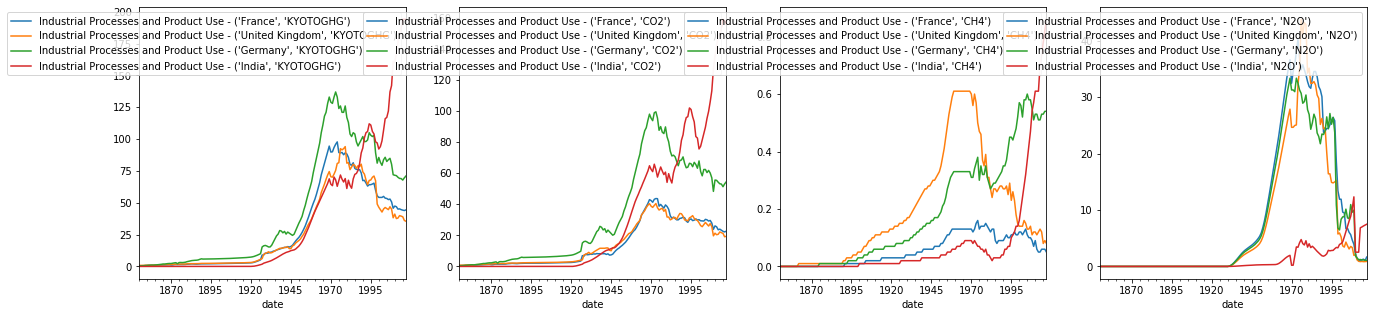

In [19]:
gases = ["KYOTOGHG", "CO2", "CH4", "N2O"]
countries = ["France", "United Kingdom", "Germany", "India"]
Sectors = ["Industrial Processes and Product Use"]

fig, axs = plt.subplots(1,len(gases))
fig.set_size_inches(len(gases)*5 + 2, 5)
for i, gas in enumerate(gases):
    for country in countries:
        idx = (country, gas)
        ghg['PIK'].loc[idx].plot(x="date", y=Sectors, label=[f"{s} - {idx}" for s in Sectors], ax= axs[i])

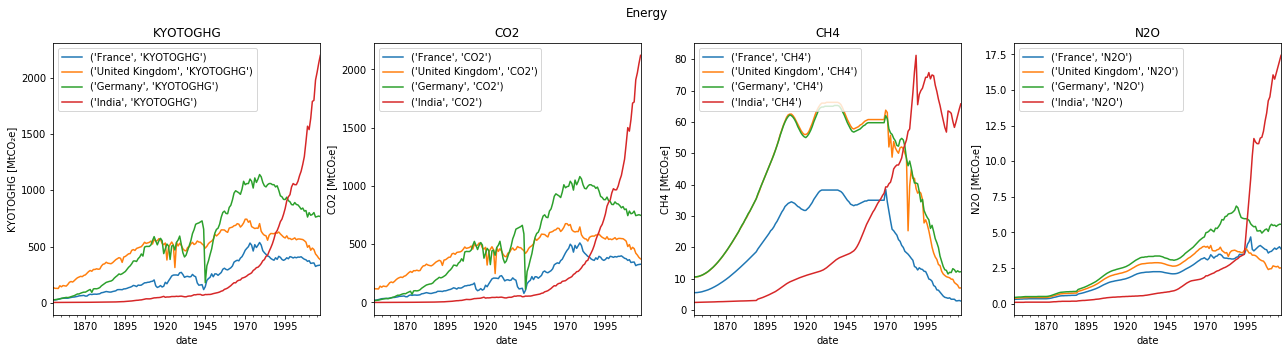

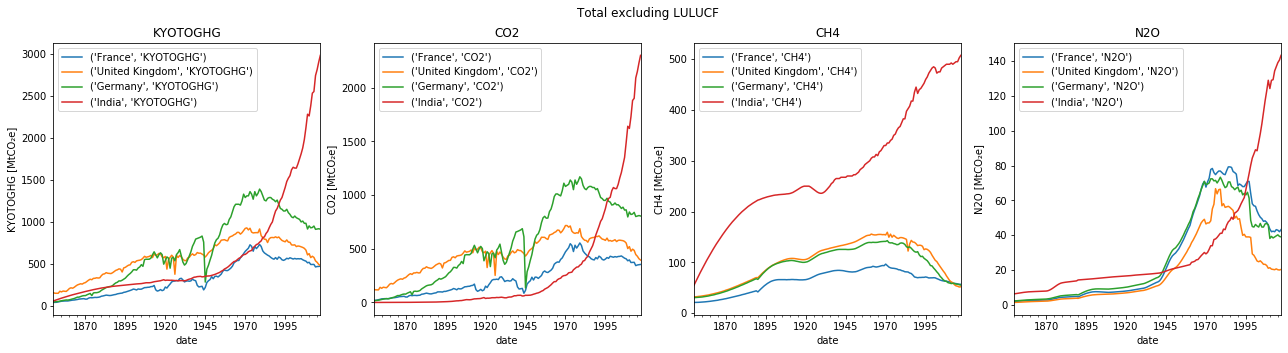

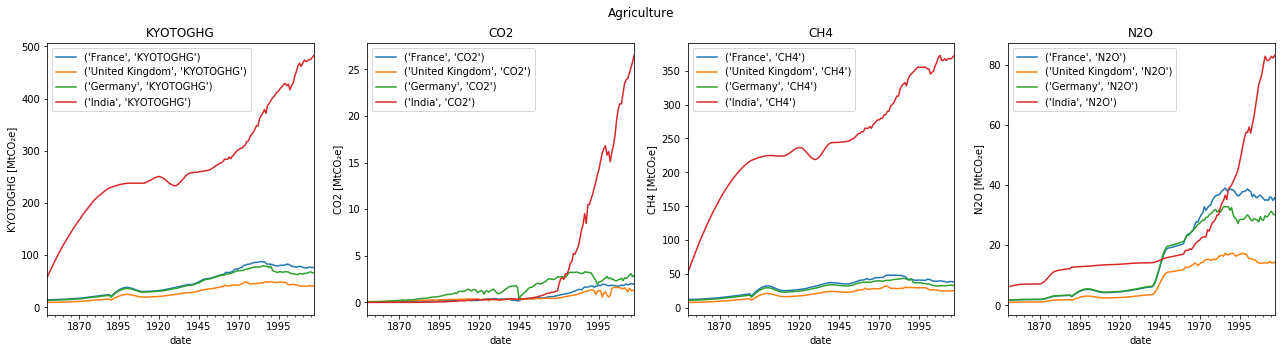

In [20]:
Sectors = [
    "Energy",
    "Total excluding LULUCF",
    "Agriculture",
]
for sector in Sectors:
    fig, axs = plt.subplots(1,len(gases))
    fig.suptitle(sector)
    fig.set_size_inches(len(gases)*5 + 2, 5)
    for i, gas in enumerate(gases):
        for country in countries:
            idx = (country, gas)
            ghg['PIK'].loc[idx].plot(x="date", y=sector, label=f"{idx}", ax= axs[i])
        unit = ghg['PIK'].loc[idx, "Unit"].unique()[-1]
        axs[i].set_ylabel(f"{gas} [{unit}]")
        axs[i].set_title(f"{gas}")

#### Looking at the UNFCCC data (deprecated)

This is official data from the UNFCCC

In [21]:
ghg["UNFCCC"] = ghg_all[
    (ghg_all["Data source"] == 'UNFCCC_NAI') 
    | (ghg_all["Data source"] == 'UNFCCC_AI')
]
ghg["UNFCCC"] = ghg["UNFCCC"][ghg["UNFCCC"].Gas == 'Aggregate GHGs']

In [22]:
for group_id, group in ghg["UNFCCC"].groupby(["Sector"]):
    print(f"group: {group_id}")
    print_df_info(group, ["Country", "Data source"], limit_print_len = 0)

group: Agriculture
'Country' has 192 unique items:
'Data source' has 2 unique items:
group: Energy
'Country' has 192 unique items:
'Data source' has 2 unique items:
group: Industrial Processes
'Country' has 148 unique items:
'Data source' has 1 unique items:
group: Industrial Processes and Product Use
'Country' has 44 unique items:
'Data source' has 1 unique items:
group: Land Use, Land-Use Change and Forestry
'Country' has 44 unique items:
'Data source' has 1 unique items:
group: Land-Use Change and Forestry
'Country' has 148 unique items:
'Data source' has 1 unique items:
group: Other
'Country' has 192 unique items:
'Data source' has 2 unique items:
group: Solvent and Other Product Use
'Country' has 148 unique items:
'Data source' has 1 unique items:
group: Total GHG emissions excluding LULUCF/LUCF
'Country' has 147 unique items:
'Data source' has 1 unique items:
group: Total GHG emissions including LULUCF/LUCF
'Country' has 148 unique items:
'Data source' has 1 unique items:
group: 

The grouping above reveals that Sector names do not exactly match between the two data sources:

In [23]:
ghg["UNFCCC"].Sector[ghg["UNFCCC"].Sector == 'Industrial Processes and Product Use'] = 'Industrial Processes'
ghg["UNFCCC"].Sector[ghg["UNFCCC"].Sector == 'Land Use, Land-Use Change and Forestry'] = 'Land-Use Change and Forestry'
ghg["UNFCCC"].Sector[ghg["UNFCCC"].Sector == 'Total GHG emissions including LULUCF/LUCF'] = 'Total GHG emissions with LULUCF'
ghg["UNFCCC"].Sector[ghg["UNFCCC"].Sector == 'Total GHG emissions excluding LULUCF/LUCF'] = 'Total GHG emissions without LULUCF'

In [24]:
for group_id, group in ghg["UNFCCC"].groupby(["Sector"]):
    print(group_id)
    print_df_info(group, ["Country"], limit_print_len = 0)

Agriculture
'Country' has 192 unique items:
Energy
'Country' has 192 unique items:
Industrial Processes
'Country' has 192 unique items:
Land-Use Change and Forestry
'Country' has 192 unique items:
Other
'Country' has 192 unique items:
Solvent and Other Product Use
'Country' has 148 unique items:
Total GHG emissions with LULUCF
'Country' has 192 unique items:
Total GHG emissions without LULUCF
'Country' has 190 unique items:
Waste
'Country' has 192 unique items:


## Data rearranging

From this wide dataset let us pivot to have sectors as columns

In [25]:
ghg["UNFCCC"].columns

Index(['Country', 'Data source', 'Sector', 'Gas', 'Unit', '2018', '2017',
       '2016', '2015', '2014',
       ...
       '1858', '1857', '1856', '1855', '1854', '1853', '1852', '1851', '1850',
       'max_year'],
      dtype='object', length=175)

In [26]:
source = "UNFCCC"
index_cols = ["Country", "GH_Gas", "date"]

ghg[source] = pivot_dates_Sector(ghg[source])
ghg[source].set_index(
    pd.MultiIndex.from_frame(ghg[source][index_cols]
), inplace=True)

## Output processed data

Here we output the processed data

In [27]:
proc_data_dir = 'data/processed'
if not os.path.exists(proc_data_dir):
    os.makedirs(proc_data_dir)

In [28]:
file_name_stub = 'historical_GHG_Sectors_{}.csv'.format
for source in ghg:
    file_path = os.path.join(proc_data_dir, file_name_stub(source))
    ghg[source].to_csv(file_path)
